In [34]:
import csv
import math
import numpy as np
import pandas as pd
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import warnings
#suppress warnings
warnings.filterwarnings('ignore')
# Set up the constants
mu_0 = 4 * math.pi * 1e-7  # Permeability of free space

# Set up the parameters for the data
I_values = np.linspace(10,50,5)  # Values of I to use


In [35]:
x=np.linspace(-40,40,5)    # x-position of the testing point
y=np.linspace(-40,40,5)    # y-position of the testing point
H=np.linspace(10,50,5)     # Height of the wire

# coeffcients of the line given by the equation ax+by+c=0
a=[-4,-3,-2,2,3,4]   
b=[-4,-3,-2,2,3,4]   
c=[-4,-3,-2,2,3,4]   


In [36]:

# Create the header row for the CSV file
header_row = ['I', 'H', 'X', 'Y', 'a', 'b', 'c', 'B']

# Create a list to store the rows of data
data_rows = []

# Loop over the I and R values and calculate the corresponding B values
for I in I_values:
  for n in H:
    for m in x:
      for j in y:
        for q in a:
          for w in b:
            for e in c:
              R=np.abs(q*m+w*j+e)/np.sqrt(q**2+w**2)
              B = mu_0 * I / (2 * math.pi * np.sqrt(R**2+n**2))
              data_rows.append([I, n, m, j, q, w, e, B])

# Write the data to a CSV file
with open('biot_savart_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header_row)
    writer.writerows(data_rows)

data=pd.read_csv('biot_savart_data.csv', sep=',')
#data=preprocessing.normalize(data)
data=(data-data.mean())/data.std()
data

,I,H,X,Y,a,b,c,B
0,-1.414208,-1.414208,-1.414208,-1.414208,-1.28653,-1.28653,-1.286530,-1.009141
1,-1.414208,-1.414208,-1.414208,-1.414208,-1.28653,-1.28653,-0.964898,-1.009892
2,-1.414208,-1.414208,-1.414208,-1.414208,-1.28653,-1.28653,-0.643265,-1.010638
3,-1.414208,-1.414208,-1.414208,-1.414208,-1.28653,-1.28653,0.643265,-1.013579
4,-1.414208,-1.414208,-1.414208,-1.414208,-1.28653,-1.28653,0.964898,-1.014303
...,...,...,...,...,...,...,...,...
134995,1.414208,1.414208,1.414208,1.414208,1.28653,1.28653,-0.964898,-0.326841
134996,1.414208,1.414208,1.414208,1.414208,1.28653,1.28653,-0.643265,-0.328469
134997,1.414208,1.414208,1.414208,1.414208,1.28653,1.28653,0.643265,-0.334947
134998,1.414208,1.414208,1.414208,1.414208,1.28653,1.28653,0.964898,-0.336557


In [37]:
I_noise = np.random.normal(np.mean(np.array(data['I'])),1,40)
X_noise = np.random.normal(np.mean(np.array(data['X'])),1,40)
H_noise = np.random.normal(np.mean(np.array(data['H'])),1,40)
Y_noise = np.random.normal(np.mean(np.array(data['Y'])),1,40)
a_noise = np.random.normal(np.mean(np.array(data['a'])),1,40)
b_noise = np.random.normal(np.mean(np.array(data['b'])),1,40)
c_noise = np.random.normal(np.mean(np.array(data['c'])),1,40)
B_noise = np.random.normal(np.mean(np.array(data['B'])),1,40)
noise=pd.DataFrame({'I': I_noise, 'H': H_noise, 'X': X_noise, 'Y': Y_noise, 'a':a_noise, 'b':b_noise, 'c':c_noise, 'B': B_noise})
data=data.append(noise, ignore_index=True)
data=np.array(data)
print(len(data))

135040


In [38]:
X=[[row[0], row[1], row[2], row[3], row[4], row[5], row[6]] for row in data]
y=[row[7] for row in data]
# Split the data into training and testing sets with a 70/30 split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Move data to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

In [39]:
# Define the model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 1)
        self.tanh = nn.Tanh()
        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.tanh(self.fc5(x))
        x = self.fc6(x)
        return x

model = Net().to(device)

# Define the loss function and optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.001)



# Train the model on GPU
train_loss = []
test_loss = []
for epoch in range(50):
    running_train_loss = 0.0
    running_test_loss = 0.0
    for i in range(0, len(x_train), 128):
        # Train
        inputs = x_train[i:i+128]
        labels = y_train[i:i+128]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)

    # Evaluate on test set
    with torch.no_grad():
        for i in range(0, len(x_test), 128):
            inputs = x_test[i:i+128]
            labels = y_test[i:i+128]

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_train_loss / len(x_train)
    epoch_test_loss = running_test_loss / len(x_test)
    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

    print(f"Epoch {epoch+1:3d} | Train loss: {epoch_train_loss:.6f} | Test loss: {epoch_test_loss:.6f}")   # 28s

Epoch   1 | Train loss: 0.660380 | Test loss: 0.653869
Epoch   2 | Train loss: 0.656204 | Test loss: 0.653362
Epoch   3 | Train loss: 0.656010 | Test loss: 0.653240
Epoch   4 | Train loss: 0.655914 | Test loss: 0.653166
Epoch   5 | Train loss: 0.655848 | Test loss: 0.653117
Epoch   6 | Train loss: 0.655803 | Test loss: 0.653084
Epoch   7 | Train loss: 0.655772 | Test loss: 0.653062
Epoch   8 | Train loss: 0.655751 | Test loss: 0.653047
Epoch   9 | Train loss: 0.655736 | Test loss: 0.653036
Epoch  10 | Train loss: 0.655725 | Test loss: 0.653029
Epoch  11 | Train loss: 0.655718 | Test loss: 0.653024
Epoch  12 | Train loss: 0.655713 | Test loss: 0.653020
Epoch  13 | Train loss: 0.655710 | Test loss: 0.653018
Epoch  14 | Train loss: 0.655707 | Test loss: 0.653016
Epoch  15 | Train loss: 0.655705 | Test loss: 0.653015
Epoch  16 | Train loss: 0.655704 | Test loss: 0.653015
Epoch  17 | Train loss: 0.655703 | Test loss: 0.653014
Epoch  18 | Train loss: 0.655702 | Test loss: 0.653014
Epoch  19 

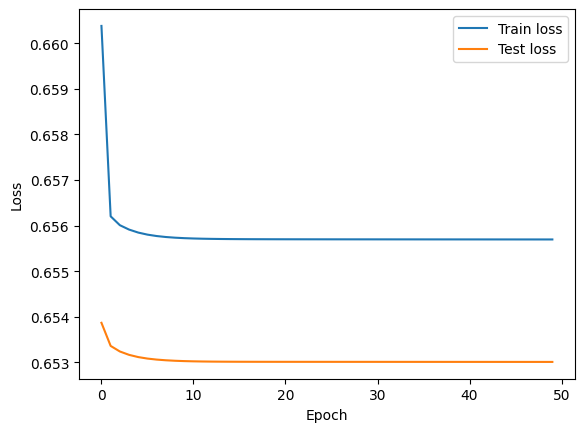

Final train loss: 0.655697
Final test loss: 0.653011


In [41]:
# Plot the train and test loss as a function of the training time
plt.plot(train_loss, label='Train loss')
plt.plot(test_loss, label='Test loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Report the final training and test loss
print(f"Final train loss: {train_loss[-1]:.6f}")
print(f"Final test loss: {test_loss[-1]:.6f}")
